# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Импорты

In [31]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from IPython.display import HTML, display
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    ParameterSampler,
    KFold
)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import root_mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.utils import resample
from scipy.stats import randint, uniform

from tqdm import tqdm
import time

# уберем лишние выводы при обучении моделей
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import logging
logging.getLogger("sklearn").setLevel(logging.ERROR)

import xgboost as xgb
xgb_params = {"verbosity": 0}


### Константы

In [32]:
# зафиксируем константы
RANDOM_STATE = 20
TEST_SIZE = 0.25
N_JOBS = -1
N_ITER = 10 # число итераций для перебора и поиска лучших параметров
N_CROSS_VALL = 3

# Функции для работы

In [33]:
# форматирования текста
def format_display(text):
    return HTML(f"<span style='font-size: 1.5em; font-weight: bold; font-style: italic;'>{text}</span>")

# сделаем функцию оценки пропусков в датасетах
def missing_data(data):
    missing_data = data.isna().sum()
    missing_data = missing_data[missing_data > 0]
    display(missing_data)

# функция для обработки пробелов
def process_spaces(s):
    if isinstance(s, str):
        s = s.strip()
        s = ' '.join(s.split())
    return s

# замена пробелов на нижнее подчеркинвание в названии столбцов
def replace_spaces(s):
    if isinstance(s, str):
        s = s.strip()
        s = '_'.join(s.split())
    return s

def drop_duplicated(data):
    # проверка дубликатов
    display(format_display("Проверим дубликаты и удалим, если есть"))
    num_duplicates = data.duplicated().sum()
    display(num_duplicates)
    
    if num_duplicates > 0:
        display("Удаляем")
        data = data.drop_duplicates(keep='first').reset_index(drop=True)  # обновляем DataFrame
    else:
        display("Дубликаты отсутствуют")
    return data

def check_data(data):
    # приведем все к нижнему регистру
    data.columns = data.columns.str.lower()
    
    # удалим лишние пробелы в строках
    data = data.applymap(process_spaces)

    # и в названии столбцов
    data.columns = [replace_spaces(col) for col in data.columns]
    
    # общая информация 
    display(format_display("Общая информация базы данных"))
    display(data.info())
    
    # 5 строк
    display(format_display("5 случайных строк"))
    display(data.sample(5))
    
    # пропуски
    display(format_display("Число пропусков в базе данных"))
    display(missing_data(data))

    # проверка на наличие пропусков
    if data.isnull().sum().sum() > 0:
        display(format_display("Визуализация пропусков"))
        msno.bar(data)
        plt.show()
        
    # средние характеристики
    display(format_display("Характеристики базы данных"))
    display(data.describe().T)
    
    data = drop_duplicated(data)
    
    return data  # возвращаем измененные данные

def plot_combined(data, col=None, target=None, col_type=None, legend_loc='best'):
    """
    Строит графики для числовых столбцов в DataFrame, автоматически определяя их типы (дискретные или непрерывные).

    :param data: DataFrame, содержащий данные для визуализации.
    :param col: Список столбцов для построения графиков. Если None, будут использованы все числовые столбцы.
    :param target: Столбец, по которому будет производиться разделение (для hue в графиках).
    :param col_type: Словарь, определяющий типы столбцов ('col' для непрерывных и 'dis' для дискретных).
                     Если None, типы будут определены автоматически.
    :param legend_loc: Положение легенды для графиков (по умолчанию 'best').
    :return: None. Графики отображаются с помощью plt.show().
    """
    
    # Определяем числовые столбцы
    if col is None:
        numerical_columns = data.select_dtypes(include=['int', 'float']).columns.tolist()
    else:
        numerical_columns = col

    # Если col_type не указан, определяем типы автоматически
    if col_type is None:
        col_type = {}
        for col in numerical_columns:
            unique_count = data[col].nunique()
            if unique_count > 20:
                col_type[col] = 'col'  # Непрерывные данные
            else:
                col_type[col] = 'dis'  # Дискретные данные

    total_plots = len(numerical_columns) * 2
    ncols = 2
    nrows = (total_plots + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))
    axs = axs.flatten()

    index = 0

    for col in numerical_columns:
        # Определяем тип графика
        plot_type = col_type.get(col)
        if plot_type is None:
            raise ValueError(f"Тип для столбца '{col}' не указан в col_type.")

        # Гистограмма или countplot
        if index < len(axs):
            if plot_type == 'col':
                if target is not None:
                    sns.histplot(data, x=col, hue=target, bins=20, kde=True, ax=axs[index])
                    handles, labels = axs[index].get_legend_handles_labels()
                    if handles:
                        axs[index].legend(title=target, loc=legend_loc)
                else:
                    sns.histplot(data[col].dropna(), bins=20, kde=True, ax=axs[index])
                axs[index].set_title(f'Гистограмма: {col}')
            elif plot_type == 'dis':
                if target is not None:
                    sns.countplot(data=data, x=col, hue=target, ax=axs[index])
                    handles, labels = axs[index].get_legend_handles_labels()
                    if handles:
                        axs[index].legend(title=target, loc=legend_loc)
                else:
                    sns.countplot(data=data, x=col, ax=axs[index])
                axs[index].set_title(f'Countplot: {col}')
                # поворот подписей X для дискретных
                axs[index].tick_params(axis='x', rotation=90)
            index += 1

        # Боксплот
        if index < len(axs):
            sns.boxplot(x=data[col], ax=axs[index])
            axs[index].set_title(f'Боксплот: {col}')
            # тоже поворачиваем, если дискретные значения
            if plot_type == 'dis':
                axs[index].tick_params(axis='x', rotation=90)
            index += 1

    # Отключаем оставшиеся оси
    for j in range(index, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()
    
def plot_categorical_columns(data, col=None, target=None, top_n=None):
    """
    Визуализация категориальных столбцов: только столбчатые графики (с группировкой по target).
    top_n — показывать только top_n категорий, остальные сворачивать в 'other'.
    """
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()

    if col is not None:
        if col not in data.columns:
            print(f"Столбец '{col}' не найден в DataFrame.")
            return
        categorical_columns = [col]

    if len(categorical_columns) == 0:
        print("Категориальных столбцов нет.")
        return

    n = len(categorical_columns)
    ncols = 2
    nrows = (n + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))
    if isinstance(axs, np.ndarray):
        axs = axs.flatten()
    else:
        axs = [axs]

    idx = 0
    for c in categorical_columns:
        # value_counts с NaN
        vc = data[c].fillna('NaN').value_counts()

        if top_n is not None and len(vc) > top_n:
            head = vc.iloc[:top_n].copy()
            rest = vc.iloc[top_n:].sum()
            head['other'] = rest
            vc = head

        labels = vc.index.tolist()
        cmap = plt.colormaps.get_cmap('tab20').resampled(max(1, len(labels)))
        colors = [cmap(i) for i in range(len(labels))]

        if target is not None and target in data.columns:
            grouped = data.groupby([target, c]).size().unstack(fill_value=0)
            cmap2 = plt.cm.get_cmap('tab20', max(1, len(grouped.columns)))
            bar_colors = [cmap2(i) for i in range(len(grouped.columns))]
            grouped.plot(kind='bar', ax=axs[idx], color=bar_colors)
            axs[idx].legend(title=target)
        else:
            vc.plot(kind='bar', ax=axs[idx], color=colors)

        axs[idx].set_title(f'{c} (гистограмма)')
        axs[idx].set_ylabel('Частота')
        axs[idx].tick_params(axis='x', rotation=90)
        idx += 1

    for j in range(idx, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()
    
def analyze_data(dataframes, drop_columns):
    """
    Анализирует данные, удаляет указанные столбцы и строит графики распределения
    для общих числовых столбцов.

    :param dataframes: Список баз данных (списки pandas DataFrame)
    :param drop_columns: Список столбцов для удаления (список строк)
    """

    cleaned_data = [df.drop(columns=drop_columns, errors='ignore') for df in dataframes]
    
    # Находим общие числовые столбцы
    common_columns = set(cleaned_data[0].select_dtypes(include=['float64', 'int64']).columns)
    for df in cleaned_data[1:]:
        common_columns.intersection_update(df.select_dtypes(include=['float64', 'int64']).columns)

    if not common_columns:
        print("Нет общих числовых столбцов для анализа.")
        return

    # Преобразуем множество в список
    common_columns = list(common_columns)

    combined_data = pd.concat(
        [df[common_columns].assign(dataset=f'base_{i+1}') for i, df in enumerate(cleaned_data)],
        keys=[f'base_{i+1}' for i in range(len(cleaned_data))],
        names=['dataset', 'index']
    )

    palette = {f'base_{i+1}': 'blue' if i == 0 else 'orange' for i in range(len(cleaned_data))}
    
    for column in common_columns:
        plt.figure(figsize=(10, 6))
        sns.kdeplot(data=combined_data, x=column, hue='dataset', common_norm=False, fill=True, palette=palette)
        plt.title(f'Распределение {column}')
        plt.xlabel(column)
        plt.ylabel('Плотность')
        
        handles, labels = plt.gca().get_legend_handles_labels()
        if handles:
            plt.legend(title='Набор данных', loc='best', labels=[f'Таблица {label}' for label in labels])
        
        plt.show()

# Подготовка данных

## Подключим и почитаем базу

In [34]:
df = pd.read_csv("autos.csv")

C:\Users\root6\AppData\Local\Temp\ipykernel_1328512\1319312393.py:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(process_spaces)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  repaired           283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

None

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
243669,2016-03-27 18:50:13,2000,NaN,2018,manual,90,golf,150000,0,gasoline,volkswagen,NaN,2016-03-27 00:00:00,0,56729,2016-04-05 15:46:47
5896,2016-03-10 13:57:00,999,small,1996,manual,45,corsa,20000,3,petrol,opel,no,2016-03-10 00:00:00,0,69207,2016-03-12 17:48:29
21310,2016-03-15 06:03:14,800,coupe,1995,auto,0,3er,150000,0,petrol,bmw,NaN,2016-03-15 00:00:00,0,12353,2016-03-17 22:47:19
307744,2016-04-04 16:50:45,2550,sedan,2002,manual,140,a_klasse,150000,9,petrol,mercedes_benz,no,2016-04-04 00:00:00,0,85764,2016-04-06 18:46:27
240588,2016-03-19 21:50:34,1350,wagon,1996,auto,116,3er,150000,6,petrol,bmw,no,2016-03-19 00:00:00,0,22419,2016-04-01 15:16:24


vehicletype    37490
gearbox        19833
model          19705
fueltype       32895
repaired       71154
dtype: int64

None

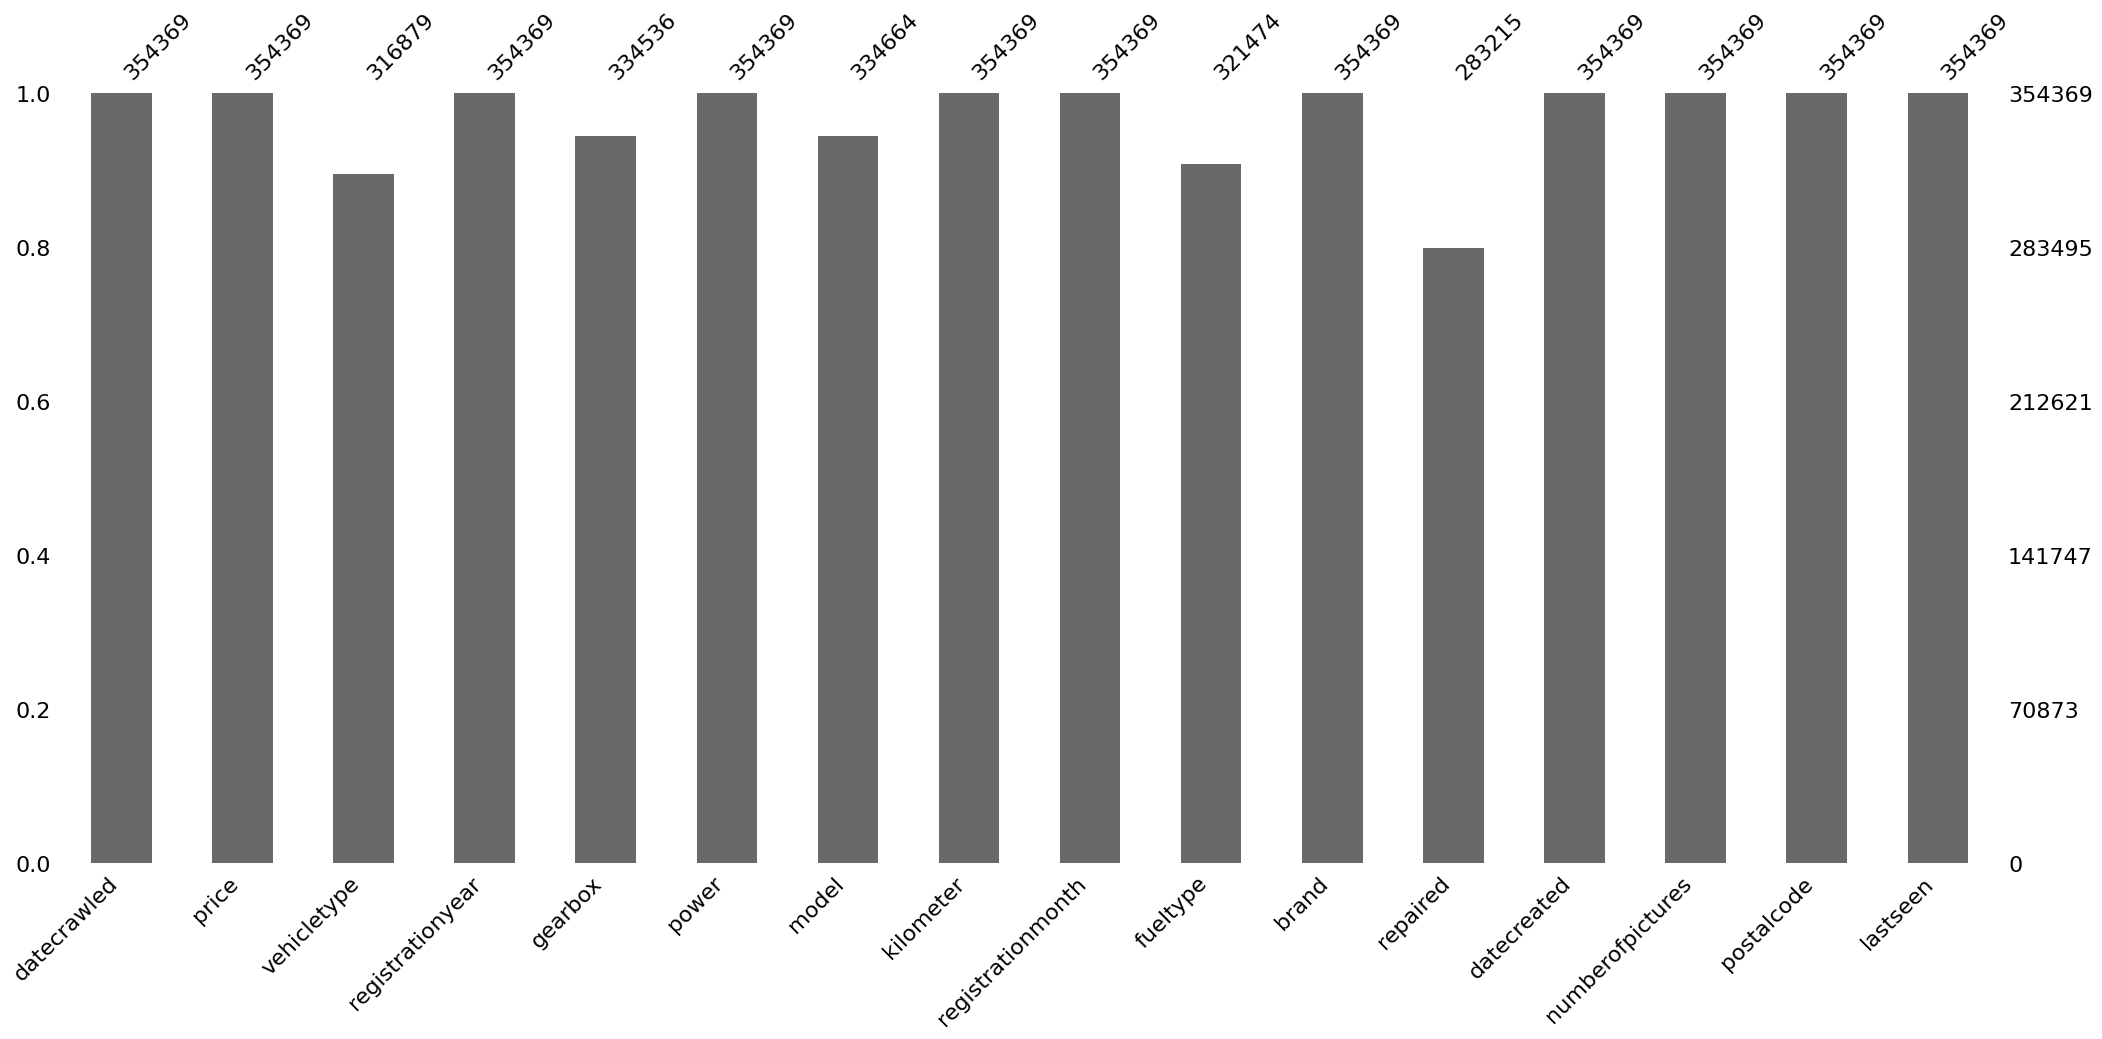

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registrationyear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
registrationmonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
numberofpictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postalcode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


np.int64(4)

'Удаляем'

In [35]:
df = check_data(df)

## Описание данных

Признаки:  
DateCrawled — дата скачивания анкеты из базы - не влияет на цену  
VehicleType — тип автомобильного кузова - влияет  
RegistrationYear — год регистрации автомобиля - влияет, вероятнее всего имелся год ввода в эксплуатацию  
Gearbox — тип коробки передач - влияет  
Power — мощность (л. с.) - влияет  
Model — модель автомобиля - влияет  
Kilometer — пробег (км) - влияет  
RegistrationMonth — месяц регистрации автомобиля - не влияет
FuelType — тип топлива - влияет  
Brand — марка автомобиля - влияет  
Repaired — была машина в ремонте или нет - влияет  
DateCreated — дата создания анкеты - не влияет  
NumberOfPictures — количество фотографий автомобиля - не влияет  
PostalCode — почтовый индекс владельца анкеты (пользователя) - не влияет  
LastSeen — дата последней активности пользователя - не влияет  

Целевой признак  
Price — цена (евро)

## Оставим влияющие на цену признаки

In [36]:
# таким образом оставим только нужные нам признаки
need_cols = ["price", "vehicletype", "registrationyear", "gearbox", "power", "model", "kilometer", "fueltype", "brand", "repaired"]
df = df[need_cols]

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             354365 non-null  int64 
 1   vehicletype       316875 non-null  object
 2   registrationyear  354365 non-null  int64 
 3   gearbox           334532 non-null  object
 4   power             354365 non-null  int64 
 5   model             334660 non-null  object
 6   kilometer         354365 non-null  int64 
 7   fueltype          321470 non-null  object
 8   brand             354365 non-null  object
 9   repaired          283211 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [38]:
missing_data(df)

vehicletype    37490
gearbox        19833
model          19705
fueltype       32895
repaired       71154
dtype: int64

## Анализ данных

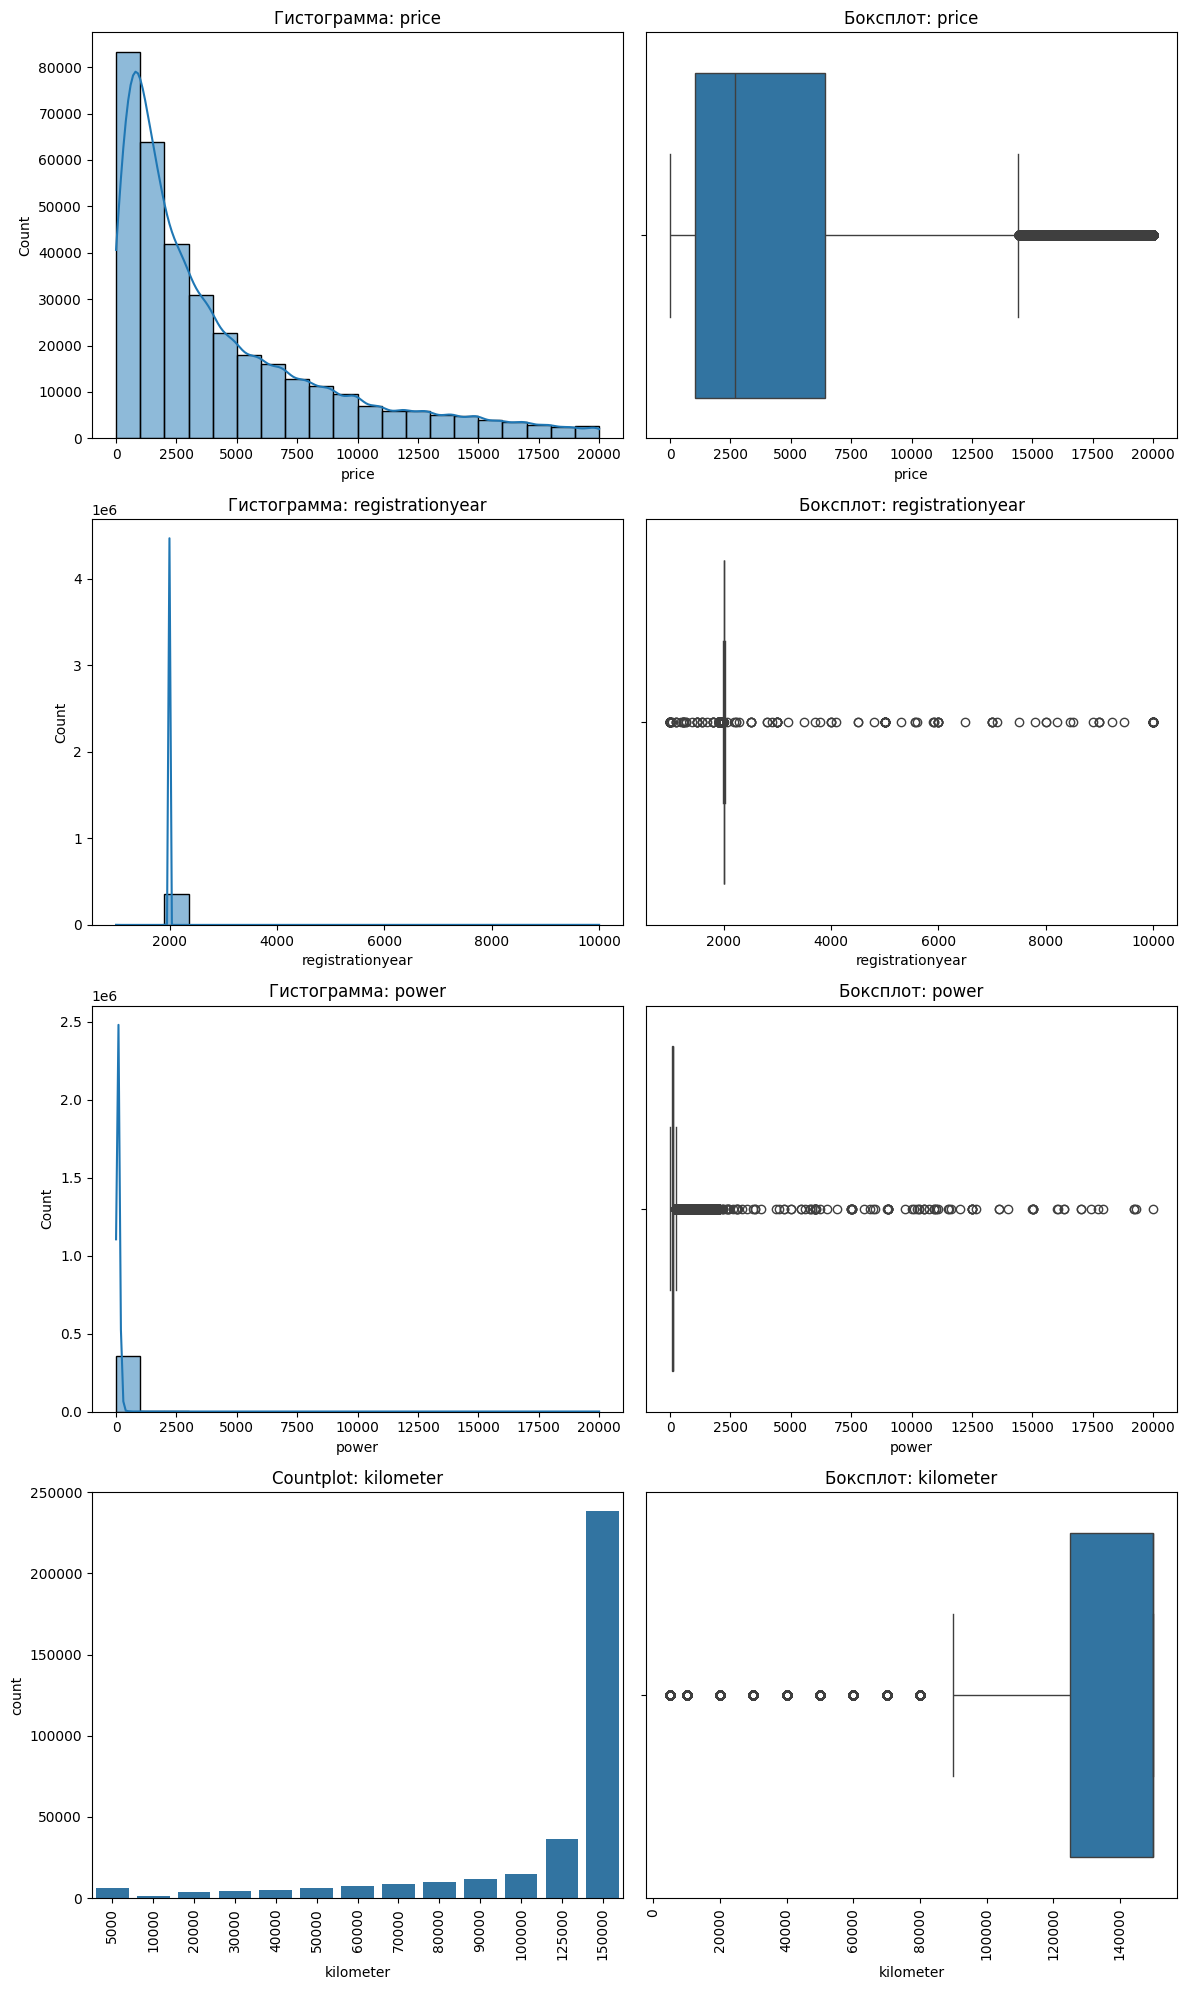

In [39]:
# вначале посмотрим что там с непрерывными данными
plot_combined(df, col=None, target=None, col_type=None, legend_loc='best')

В целом только цена и пробег выглядят адекватно, с остальными надо разбираться по отдельности

In [40]:
# посмотрим на дату регистрации
np.sort(df["registrationyear"].unique())

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Кто-то явно заполнял данные "от балды"  
Адекватный минимум, что я вижу 1910  
Адекватный максимум - текущий год  
Все, что не попадает - будет заменять на NaN

In [41]:
# посмотрим на мощность
df["power"].describe().T

count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

На август 2025 флагманом считается Gemera шведского производителя Koenigsegg с мощностью 2300 лошадиных сил, возмем, все, что выше как NaN  
0,75 л. с. — мощность первого автомобиля, созданного Карлом Бенцем, — Benz Patent Motorwagen, т.е. явно не 0, значит все, что меньше 1 лошади изменим на NaN

In [42]:
# ну и на всякий случай посмотрим, что у нас там на столько мощного в базе
display(df[df["power"] > 400])

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
2102,0,sedan,1999,NaN,1799,vectra,150000,petrol,opel,yes
2781,19500,suv,2004,auto,450,cayenne,125000,petrol,porsche,no
3289,16899,wagon,2003,auto,476,e_klasse,150000,petrol,mercedes_benz,no
3746,0,NaN,2017,manual,750,NaN,150000,petrol,smart,no
...,...,...,...,...,...,...,...,...,...,...
353489,12500,NaN,2017,manual,2000,other,60000,gasoline,chrysler,no
353629,2400,sedan,2007,manual,650,c2,150000,petrol,citroen,NaN
354041,20000,coupe,2006,auto,476,other,125000,petrol,mercedes_benz,no
354256,399,other,1994,NaN,1103,3er,150000,NaN,bmw,NaN


Матизы, астры, корсы, зафиры... с казахами все понятно :)  
Опелеводы то куда так завышают мощность своих авто?  

In [43]:
custom_percentiles = [0.05, 0.25, 0.60, 0.75, 0.95]
display(df["power"].describe(percentiles=custom_percentiles))

count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
5%            0.000000
25%          69.000000
50%         105.000000
60%         116.000000
75%         143.000000
95%         218.000000
max       20000.000000
Name: power, dtype: float64

Что и требовалось доказать - скорректируем предыдущие выводы.  
Все что меньше 1 и больше 224 преобразуем в NaN

In [44]:
# сказано - сделано
now_year = datetime.now().year
df.loc[(df["registrationyear"] < 1910) | (df["registrationyear"] > now_year), "registrationyear"] = np.nan
df.loc[(df["power"] < 1) | (df["power"] > 224), "power"] = np.nan

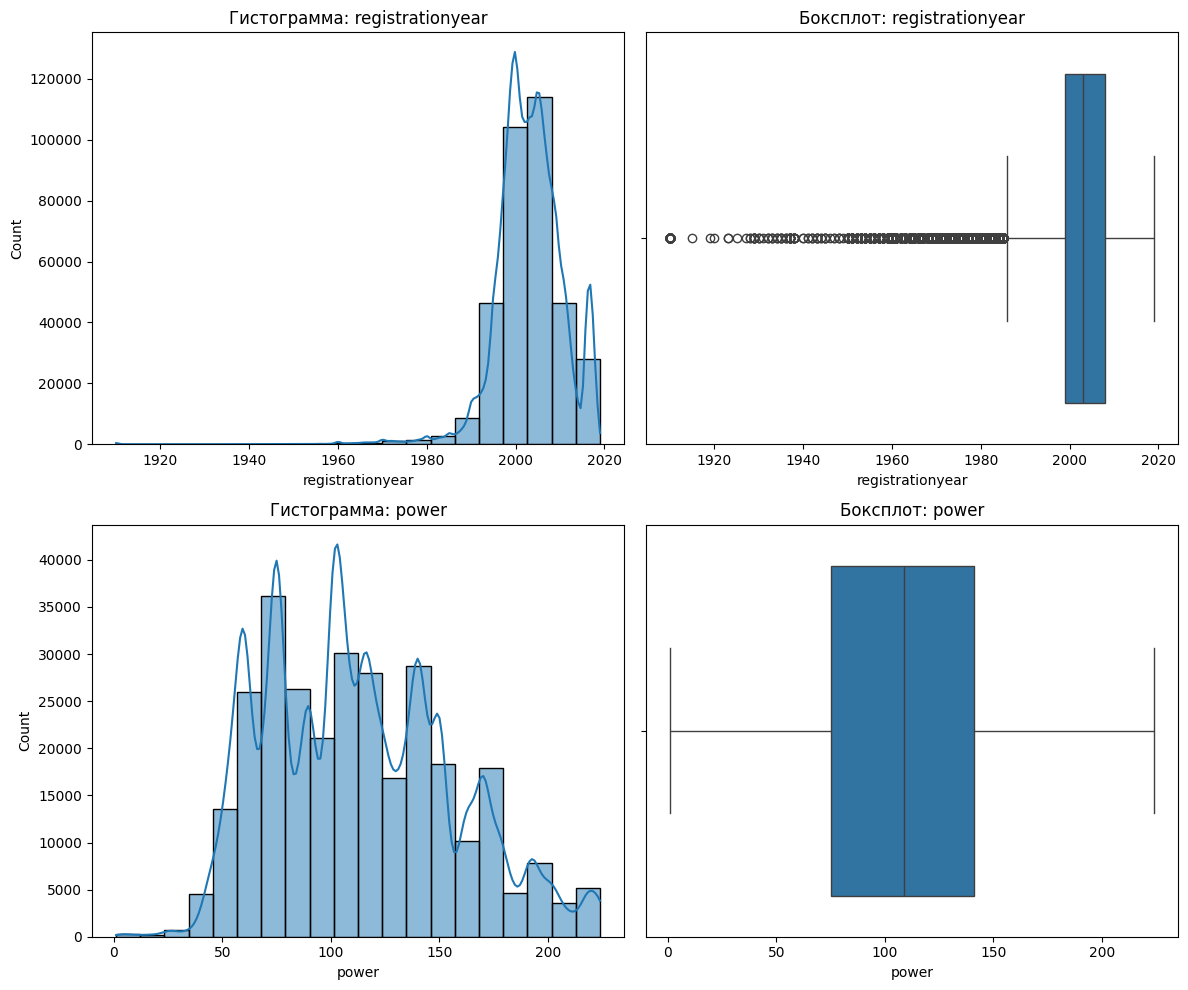

In [45]:
plot_combined(df, col=["registrationyear", "power"], target=None, col_type=None, legend_loc='best')

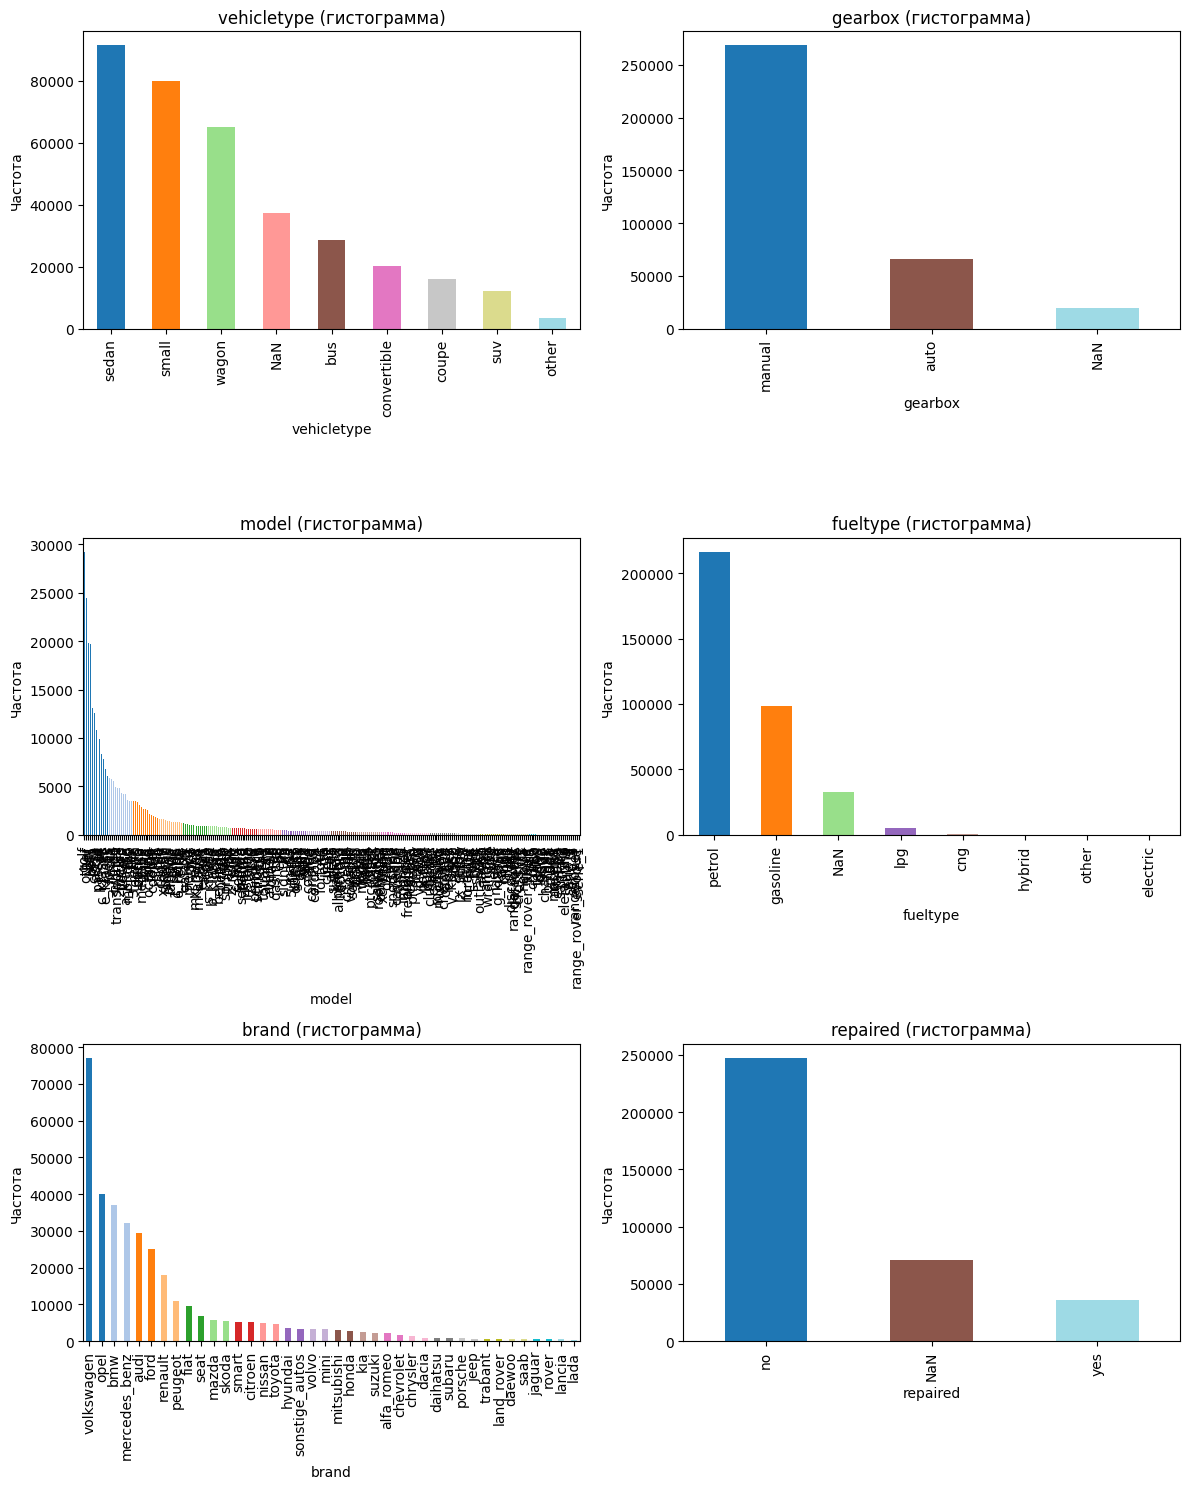

In [46]:
plot_categorical_columns(df, col=None, target=None)

Придется разобраться в моделях и брендах более детально  
Слишком всего много, возможно, есть ошибки/неявные дубли и т.д. и т.п.  

Тип кузова, тип топлива - есть и NaN и other... заменим other на NaN  
пысы - я пока везде все привожу к нану, потом посмотрим, надо как-то менять или нет (ну бусты сами справятся, с простыми моделями потом решим)

In [47]:
# модели
display(df["model"].nunique())
display(np.sort(df["model"].dropna().astype(str).unique()))


250

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

Как будто бы все выглядяит неплохо, среди того списка, что получилось вывести на экран.

In [48]:
# бренды
display(df["brand"].nunique())
display(np.sort(df["brand"].dropna().astype(str).unique()))

40

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

О как!  
sonstige_autos - перешли на немецкий язык описания "других" автомобилей :)  
Сделаем в NaN, все равно пока так делаем везде

In [49]:
# делаем
df.loc[(df["vehicletype"] == "other"), "vehicletype"] = np.nan
df.loc[(df["fueltype"] == "other"), "fueltype"] = np.nan
df.loc[(df["brand"] == "sonstige_autos"), "brand"] = np.nan

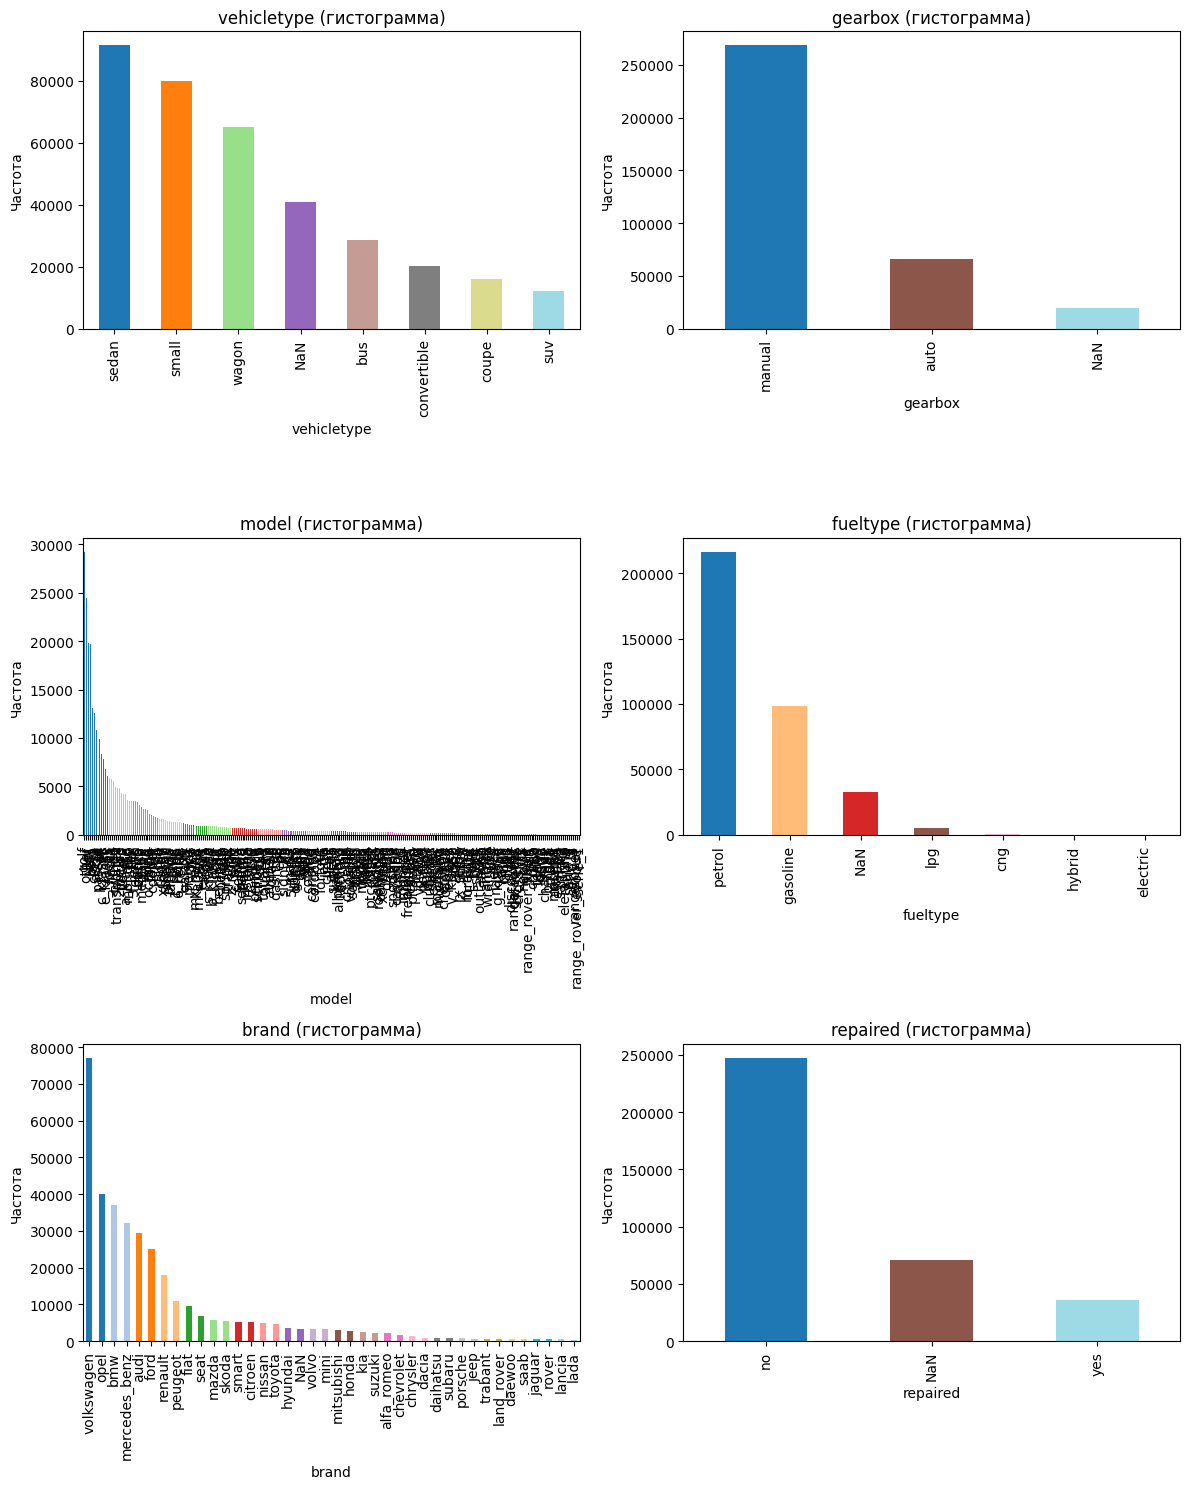

In [50]:
plot_categorical_columns(df, col=None, target=None)

Ну вот и ладненько

## Подготовим данные для обучения

### Разбивка исходной базы

In [51]:
# разделим на выборки
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['price'], axis=1),
    df['price'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

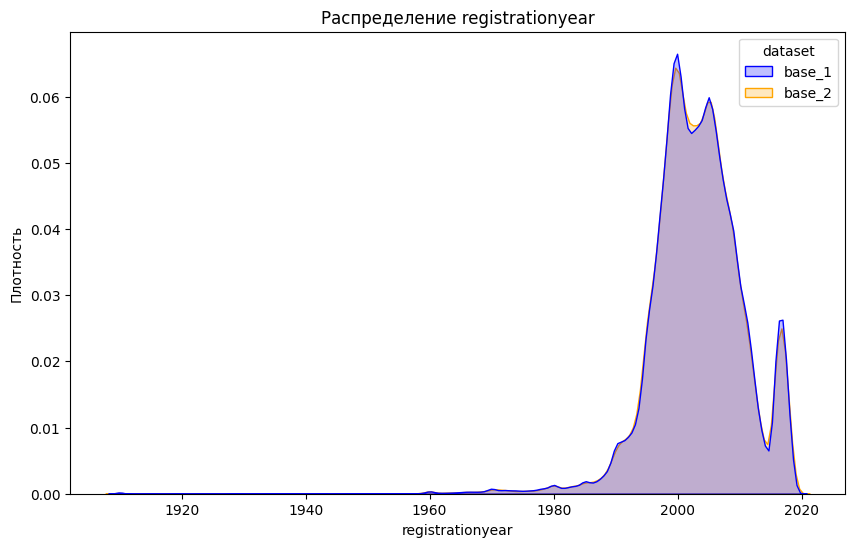

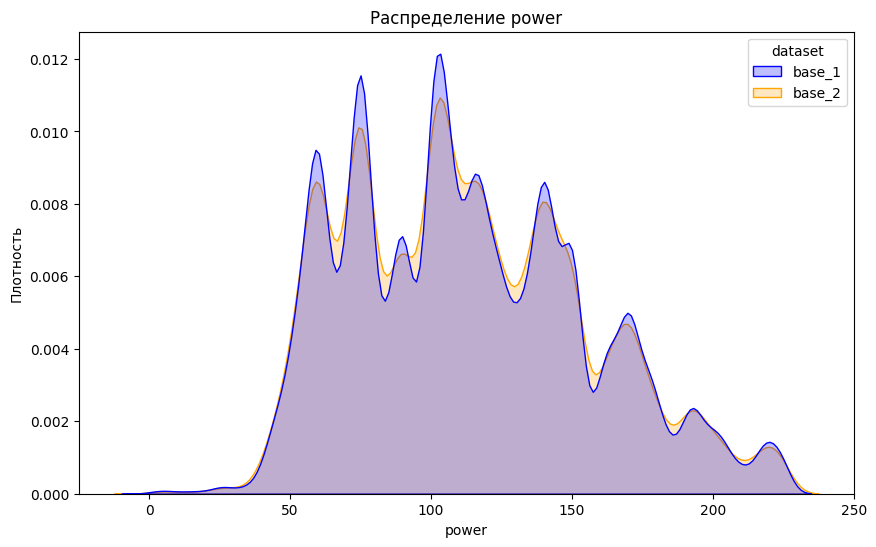

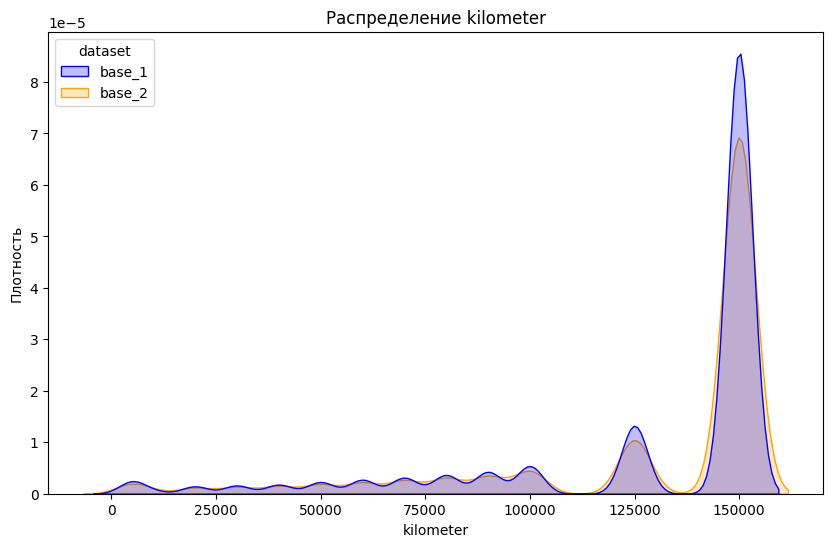

In [52]:
analyze_data([X_train, X_test], ['price'])

Данные разбились равномерно, все красиво.

# Обучение моделей

### Подготовка к обучению

In [53]:
# сюда будем писать результаты
results = {}

In [54]:
# Разделяем признаки
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns
numeric_cols = X_train.select_dtypes(exclude=["object", "category"]).columns

# Дальше разделение на one-hot и ordinal исходя из объема уникальных значений, иначе может отвалится по памяти
onehot_cols = [col for col in categorical_cols if X_train[col].nunique() <= 15]
ordinal_cols = [col for col in categorical_cols if X_train[col].nunique() > 15]

In [55]:
to_str = FunctionTransformer(lambda x: x.astype(str))

# для линейной регрессии
preprocessor_linear = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value=-1)),
            ("scaler", StandardScaler())
        ]), numeric_cols),
        ("onehot", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("to_str", to_str),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), onehot_cols),
        ("ordinal", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("to_str", to_str),
            ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
            ("scaler", StandardScaler())
        ]), ordinal_cols)
    ]
)

# для деревьев
preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value=-1))
        ]), numeric_cols),
        ("onehot", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("to_str", to_str),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), onehot_cols),
        ("ordinal", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("to_str", to_str),
            ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
        ]), ordinal_cols)
    ]
)

In [56]:
models = {
    "LinearRegression": (lambda: LinearRegression(), preprocessor_linear),
    "RandomForest": (lambda: RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS), preprocessor_tree),
    "DecisionTree": (lambda: DecisionTreeRegressor(random_state=RANDOM_STATE), preprocessor_tree),
    "LightGBM": (lambda: LGBMRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS, verbosity=-1), preprocessor_tree),
    "XGBoost": (lambda: XGBRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS, verbosity=0), preprocessor_tree),
    "CatBoost": (lambda: CatBoostRegressor(random_state=RANDOM_STATE, task_type="CPU", thread_count=N_JOBS, verbose=0), preprocessor_tree),
}

In [57]:
param_grids = {
    "LinearRegression": {
        "model__fit_intercept": [True, False],
    },

    "DecisionTree": {
        "model__criterion": ["squared_error"],
        "model__max_depth": randint(4, 10),
        "model__min_samples_split": randint(2, 10),
        "model__min_samples_leaf": randint(2, 5),
        "model__max_features": ["sqrt", "log2"],
    },

    "RandomForest": {
        "model__n_estimators": randint(20, 50),
        "model__max_depth": randint(4, 10),
        "model__min_samples_split": randint(2, 10),
        "model__min_samples_leaf": randint(2, 5),
        "model__max_features": ["sqrt", "log2"],
        "model__bootstrap": [True],
    },

    "LightGBM": {
        "model__num_leaves": randint(50, 255),
        "model__max_depth": randint(5, 15),
        "model__learning_rate": uniform(0.01, 0.3),
        "model__n_estimators": randint(100, 150),
        "model__subsample": uniform(0.6, 0.4),
        "model__colsample_bytree": uniform(0.6, 0.4),
        "model__reg_alpha": uniform(0.0, 1.0),
        "model__reg_lambda": uniform(0.0, 1.0),
        "model__min_child_samples": randint(10, 50),
    },

    "XGBoost": {
        "model__n_estimators": randint(100, 200),
        "model__max_depth": randint(3, 12),
        "model__learning_rate": uniform(0.01, 0.3),
        "model__subsample": uniform(0.6, 0.4),
        "model__colsample_bytree": uniform(0.6, 0.4),
        "model__gamma": uniform(0.0, 5.0),
        "model__min_child_weight": randint(1, 10),
        "model__reg_alpha": uniform(0.0, 1.0),
        "model__reg_lambda": uniform(0.0, 1.0),
    },

    "CatBoost": {
        "model__iterations": randint(100, 300),
        "model__depth": randint(3, 10),
        "model__learning_rate": uniform(0.01, 0.3),
        "model__l2_leaf_reg": uniform(1.0, 5.0),
        "model__border_count": randint(32, 255),
        "model__bagging_temperature": uniform(0.0, 1.0),
        "model__random_strength": uniform(0.0, 1.0),
    },
}

In [58]:
# функция для оценки сложности

def estimate_complexity(n, p, model_name, trees=100, depth=6, num_leaves=31):
    if model_name == "LinearRegression":
        train = n * (p ** 2)
        predict = p
    elif model_name == "DecisionTree":
        train = n * p * np.log2(n)
        predict = np.log2(n)
    elif model_name == "RandomForest":
        train = trees * n * np.log2(n)
        predict = trees * np.log2(n)
    elif model_name == "LightGBM":
        train = n * np.log2(n) * num_leaves
        predict = np.log2(num_leaves)
    elif model_name == "XGBoost":
        train = n * trees * depth
        predict = trees * depth
    else:
        train = predict = None

    return {
        "train": f"O({train:.2e})" if train else "N/A",
        "predict": f"O({predict:.2e})" if predict else "N/A"
    }

In [59]:
# доверительных интервал
def bootstrap_rmse(y_true, y_pred, n_bootstrap=500, random_state=RANDOM_STATE):
    np.random.seed(random_state)
    scores = []
    for _ in range(n_bootstrap):
        y_true_bs, y_pred_bs = resample(y_true, y_pred)
        scores.append(root_mean_squared_error(y_true_bs, y_pred_bs))
    return np.min(scores), np.max(scores)

### Обучение

In [60]:
results = []

kf = KFold(n_splits=N_CROSS_VALL, shuffle=True, random_state=RANDOM_STATE)

for name, (model_factory, preprocessor) in tqdm(models.items(), desc="Модели", leave=True):
    param_grid = param_grids.get(name, {})
    sampler = list(ParameterSampler(param_grid, n_iter=N_ITER, random_state=RANDOM_STATE))
    
    for params in sampler:
        pipe = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", model_factory())  # каждый раз новая модель
        ])
        
        pipe.set_params(**params)
        fold_scores = []

        for train_idx, val_idx in kf.split(X_train):
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

            pipe.fit(X_train_fold, y_train_fold)
            preds_val = pipe.predict(X_val_fold)
            fold_scores.append(root_mean_squared_error(y_val_fold, preds_val))
        
        t_start = time.time()
        pipe.fit(X_train, y_train)
        time_fit = time.time() - t_start

        t_start = time.time()
        preds = pipe.predict(X_test)
        time_predict = time.time() - t_start

        rmse = root_mean_squared_error(y_test, preds)
        rmse_min, rmse_max = bootstrap_rmse(y_test, preds)

        results.append({
            "Model": name,
            "RMSE": rmse,
            "RMSE_CV": np.mean(fold_scores),
            "RMSE_min": rmse_min,
            "RMSE_max": rmse_max,
            "Time_fit": time_fit,
            "Time_predict": time_predict,
            "Params": params,
            "CV_scores": fold_scores
        })

results_df = pd.DataFrame(results)

Модели: 100%|██████████| 6/6 [06:06<00:00, 61.07s/it]


# Анализ моделей

In [75]:
# итоговая таблица
best_model = results_df.loc[
    results_df.groupby("Model")["RMSE"].idxmin()
].reset_index(drop=True)
best_model["RMSE_delta"] = best_model["RMSE_max"] - best_model["RMSE_min"]

best_model = best_model.sort_values(by="RMSE", ascending=True).reset_index(drop=True)
display(best_model.T)

,0,1,2,3,4,5
Model,LightGBM,XGBoost,CatBoost,RandomForest,DecisionTree,LinearRegression
RMSE,1729.814968,1730.795044,1823.189916,2415.066357,2656.606294,3438.163769
RMSE_CV,1774.848167,1776.188192,1852.839135,2453.189704,2594.250029,3476.84348
RMSE_min,1696.452968,1692.759399,1790.532877,2382.768693,2622.069257,3401.26837
RMSE_max,1757.689444,1760.923706,1858.795722,2450.044978,2697.434634,3473.937016
Time_fit,1.766067,1.478054,3.512329,1.215675,1.025038,1.010036
Time_predict,0.324009,0.28801,0.538545,0.261278,0.234009,0.231009
Params,{'model__colsample_bytree': 0.7442246226804569...,{'model__colsample_bytree': 0.9496787025363427...,{'model__bagging_temperature': 0.5881308010772...,"{'model__bootstrap': True, 'model__max_depth':...","{'model__criterion': 'squared_error', 'model__...",{'model__fit_intercept': False}
CV_scores,"[1779.0620107460932, 1759.3201402216282, 1786....","[1785.5694580078125, 1759.6593017578125, 1783....","[1860.2257619152572, 1836.7438718110575, 1861....","[2464.7040628247337, 2455.3698262996186, 2439....","[2661.845385900314, 2553.6566824479582, 2567.2...","[3495.123540920235, 3478.274171696343, 3457.13..."
RMSE_delta,61.236476,68.164307,68.262845,67.276285,75.365377,72.668645


# Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей